<a href="https://colab.research.google.com/github/AndreassOlsson/FastAI/blob/main/FastAI_highlevel_recipies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI - A PyTorch library

Docs available at: https://docs.fast.ai/


In [ ]:
!pip install nbdev

## Computer vision

In [ ]:
from fastai.vision.all import *

### Single-label classification

#### Cat vs Dog classifier - High level API

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
files = get_image_files(path/'images')

In [ ]:
print(f'Number of images: {len(files)}')
print(f'Examples: {files[0:2000:1000]}')

Number of images: 7390
Examples: [Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_16.jpg'), Path('/root/.fastai/data/oxford-iiit-pet/images/saint_bernard_77.jpg')]


We see that some examples are in uppercase and some aren't. In this dataset, the cats are in uppercase while the dogs are in lowercase. We use this to get the labels for our training examples

In [ ]:
def label_func(x): return x[0].isupper()

To get the data ready for the model, we need to have it as a DataLoaders object. Since our label_func uses the file names as input, we will use ImageDataLoaders.from_name_func.

In [ ]:
doc(ImageDataLoaders.from_name_func)

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we’re working in, the files we grabbed, our label_func and one last piece as item_tfms: this is a Transform applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn’t pass this, we would get an error later as it would be impossible to batch the items together.

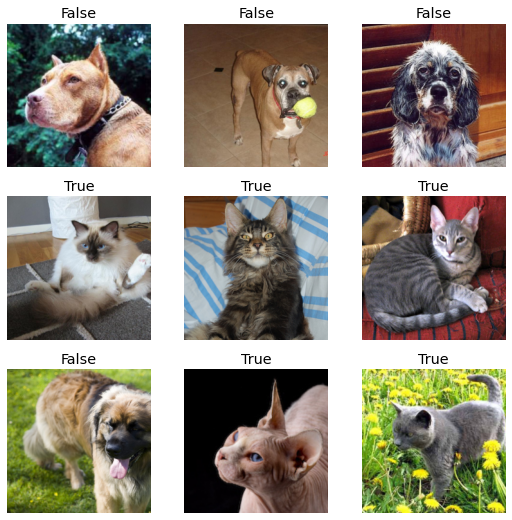

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(files[10].name)
learn.predict(files[10])

Birman_201.jpg


('True', TensorBase(1), TensorBase([1.4689e-04, 9.9985e-01]))

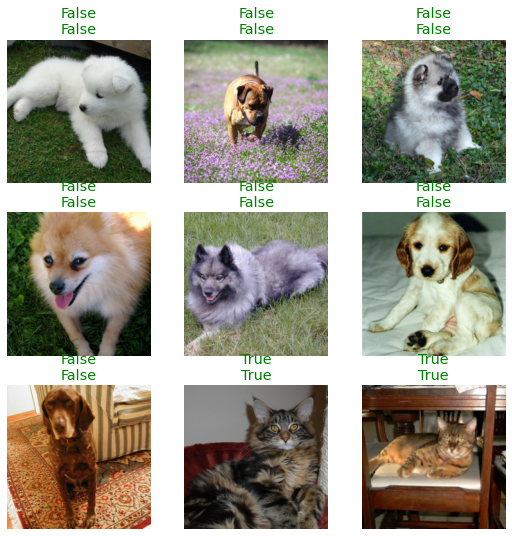

In [ ]:
learn.show_results()

#### Breed classifier - High level API

In [ ]:
files[10].name

'samoyed_33.jpg'

In [ ]:
pat = r'^(.*)_\d+.jpg'

In [ ]:
doc(ImageDataLoaders.from_name_re)

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

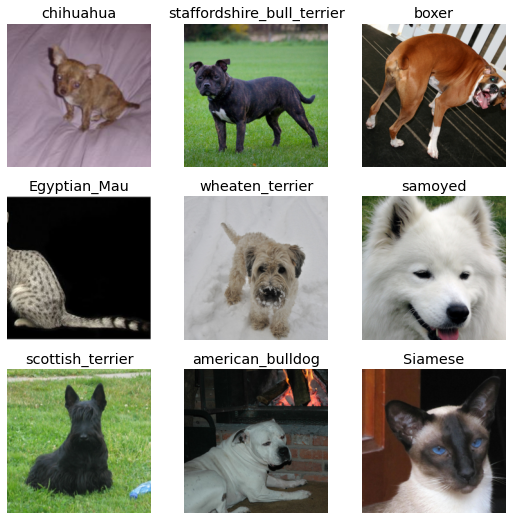

In [ ]:
dls.show_batch()

Classifying the exact breeds of dogs and cats is a harder problem. Therefor we will use data augmentation to get the most out of our training examples.

In [ ]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

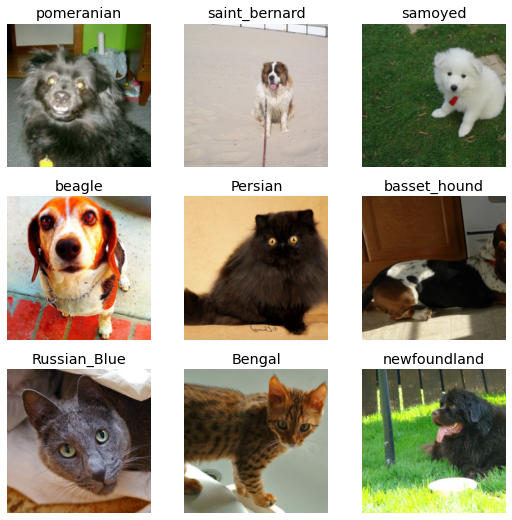

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Instead of using the default learning rate, we look for the best one

SuggestedLRs(valley=0.0014454397605732083)

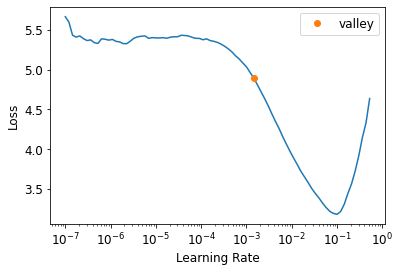

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(2, 0.0014454397605732083)

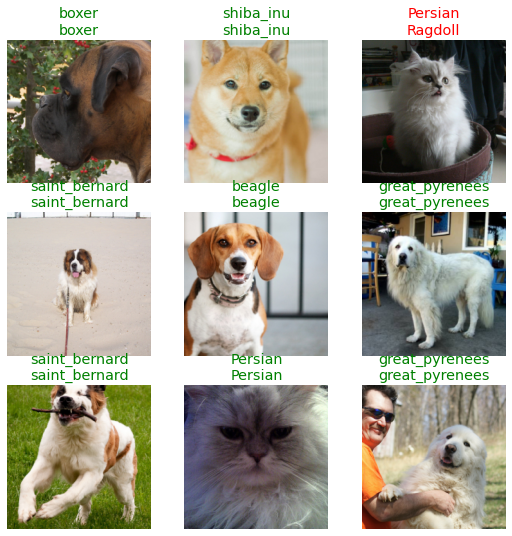

In [ ]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

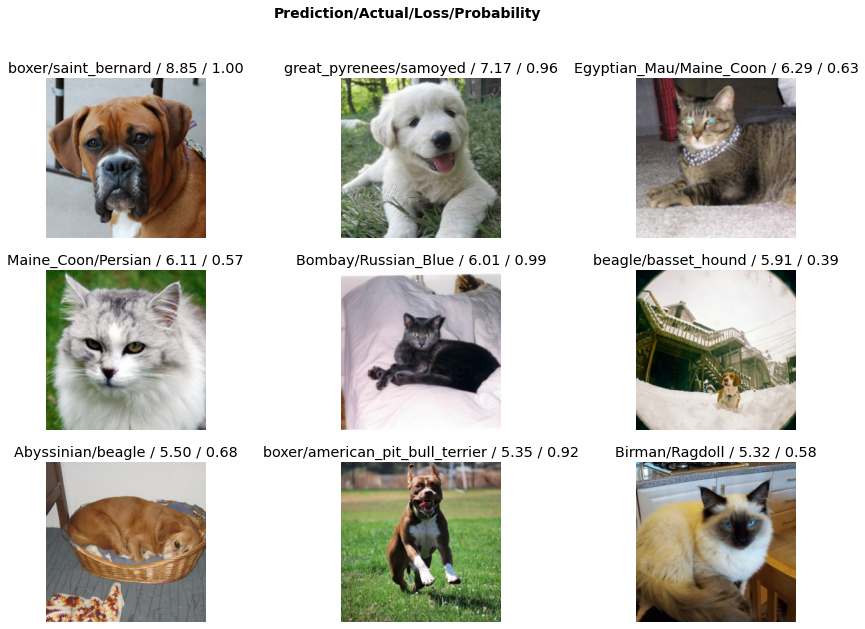

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

#### Breed classifier - DataBlock API

If we need more flexibility in our data, we start by creating a DataBlock with the data block api and then converting it to a DataLoaders object. A DataBlock takes the following instructions:

* The types used, declared through a **blocks** argument, ex: *(ImageBlock, CategoryBlock)*
* How to get the raw items, **get_items**, ex: *get_image_files*
* How to label the raw items, **get_y**, ex by using the same regular expressions function as in the previous example: *using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')*
* How to split those items, **splitter**, ex: *RandomSplitter()*
* Item & Batch transformations, **item_tfms** & **batch_tfms**, as before

In [ ]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    splitter = RandomSplitter(),
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224)
)

In [ ]:
path = untar_data(URLs.PETS)
dls = pets.dataloaders(path/'images')

Then we can continue as we did before, since we now have an identical DataLoaders object.

### Multi-label classification

In [ ]:
import pandas as pd

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.csv')]

In [ ]:
df = pd.read_csv(path/'train.csv')

In [ ]:
df.sample(3)

fname            labels  is_valid
1052  002136.jpg              bird      True
3074  006128.jpg  car person sheep     False
1789  003554.jpg         aeroplane      True

#### Multi-label classification - High level API

As we can see, each example has a filename, labels separated by space and a is_value bool. We use the factory method ImageDataLoaders.from_df to quickly load our dataframe into a DataLoaders object that takes: 

* The **df** 
* The underlying **path**
* The additional **folder** between the base path and the filenames, *'train'* as in path/'train'
* The validation set divider column **valid_col** (without this, we would take a random subset)
* The splitting argument **label_delim** that specifies how to split a multiple of labels
* Item and batch transforms, **item_tfms**, **batch_tfms**

Note that we don’t have to specify the fn_col and the label_col because they default to the first and second column respectively.

In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ', item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

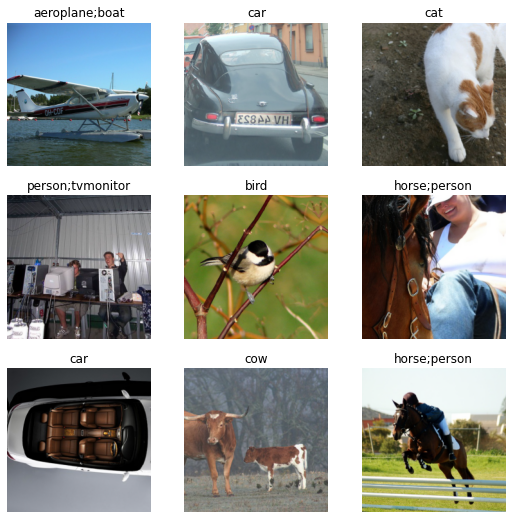

In [ ]:
dls.show_batch()

Training the model is as simple as before, since fastAI will detect that we are in a multi-label problem and thus automatically picks the right loss function. However the **metric** error_rate will not work for this problem type. We will now need to use **accuracy** with a **threshold** and multiple **F1Scores**. Here we will use F1Scores with macro and sample averaging.

In [ ]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_sample = F1ScoreMulti(thresh=0.5, average='samples')
f1_sample.name = 'F1(sample)'

In [ ]:
learn = vision_learner(dls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_sample])

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(2, 3.98e-2)

Note that **partial** is used when you don’t have ALL of the arguments for a function (or class constructor), but have a partial list of them and want to specify it before kicking the can to later down the road to fill the remaining arguments. That way you don’t have to Keep passing all the arguments around just to invoke the function later. It results in cleaner code and less API dependency.

In [ ]:
learn.show_results()

In [ ]:
learn.predict(path/'train/006128.jpg')

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(3)

#### Multi-label classification - DataBlock API

In [ ]:
import os

To rebuild the DataLoaders object using the more cusomizable DataBlock API, we need to pass:

* The types used, **blocks**, *(ImageBlock, MultiCategoryBlock)*
* How to get the input items from our dataframe, **get_x**, here we read our *fname column* and add path/'train' at the beginning to get complete filenames. 
* How to get the target labels from our dataframe, **get_y**, here we read the *labels column* and split by space.
* How to split our items, here with the **splitter** set to the *is_valid column*.
* Item and batch transformations, **item_tfms**, **batch_tfms**

In [ ]:
imgs = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    get_x = ColReader('fname', pref=str(path/'train') + os.path.sep),
    get_y = ColReader('labels', label_delim=' '),
    splitter = ColSplitter('is_valid'),
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224)
)

In this DataBlock, as opposed to the one in *Breed classifier - DataBlock API* we don't need to pass a function that gathers all the items - e.g. get_image_files, since we will pass our df to the .dataloaders() function when converting our DataBlock to a DataLoaders object. With that said, we still need to process each row of the df, hence the ColReader and ColSplitter functions. We did not use get_x before because we did not need to process each item, x. Also, get_x defaults to noop (no operation)  

To clarify, a DataBlock is just a blueprint and we need to pass it the source of our data to get a DataLoaders object.

In [ ]:
dls = imgs.dataloaders(df)

In [ ]:
dls.show_batch()

### Image segmentation

Image segmentation is about classifying each pixel of an image

In [ ]:
import numpy as np

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/labels'),Path('/root/.fastai/data/camvid_tiny/images')]

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype='str')
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

#### Segmentation - High level API

In [ ]:
fnames = get_image_files(path/'images')
print(fnames[0])
print(Path(path/'labels').ls()[0])

/root/.fastai/data/camvid_tiny/images/Seq05VD_f01320.png
/root/.fastai/data/camvid_tiny/labels/Seq05VD_f03090_P.png


In [ ]:
def label_func(fn): return path/'labels'/f'{fn.stem}_P{fn.suffix}'

In [ ]:
label_func(fnames[0])

Path('/root/.fastai/data/camvid_tiny/labels/Seq05VD_f01320_P.png')

In [ ]:
dls = SegmentationDataLoaders.from_label_func(path, bs=8, fnames=fnames, label_func=label_func, codes=codes)

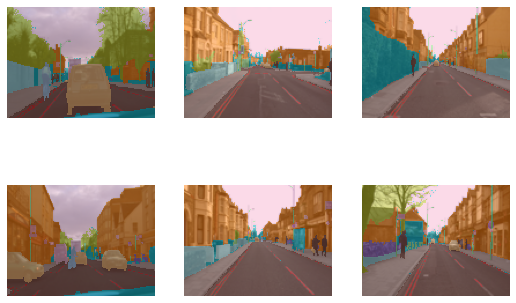

In [ ]:
dls.show_batch(max_n=6)

We use unet_learner insted of vision_learner since a traditional CNN wont work for image segmentation.

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

In [ ]:
learn.show_results()

In [ ]:
interp = SegmentationInterpretation(learn)
interp.plot_top_losses(3)

#### Segmentation - DataBlock API

For this DataBlock we need to pass as arguments:

* The types used, **blocks**, *(ImageBlock, MaskBlock(codes))*, we need to pass the codes to the MaskBlock since it has no way of guessing what class/code each segment belongs to
* How to gather our image files, **get_items**, *get_image_files*
* How to gather our labels, **get_y**, *label_func*
* How to split our datasets, **splitter**, here we will use *RandomSplitter*
* Only batch transformation, **batch_tfms** = *aug_transforms*, since all images already are the same size

In [ ]:
imgs = DataBlock(
    blocks = (ImageBlock, MaskBlock(codes)),
    get_items = get_image_files,
    get_y = label_func,
    splitter = RandomSplitter(),
    batch_tfms = aug_transforms(size=(120,160))
)

In [ ]:
dls = imgs.dataloaders(path/'images', path=path, bs=8)

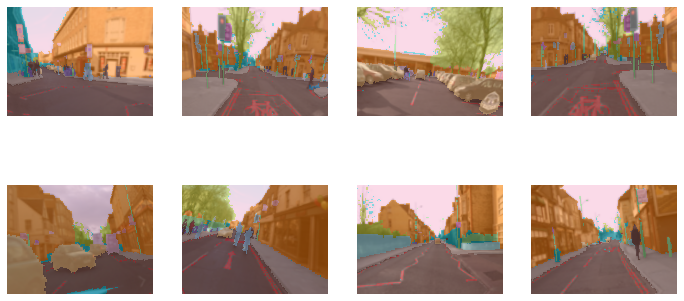

In [ ]:
dls.show_batch()

### Points

In [ ]:
import PIL

This is about predicting points in a picture. We will use the BIWI_HEAD_POSE dataset from fastai's library.

In [ ]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/11'),Path('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/08.obj'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj')...]

In [ ]:
fnames = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(fnames[0])

Path('/root/.fastai/data/biwi_head_pose/12/frame_00077_pose.txt')

In [ ]:
im = PILImage.create(fnames[2000])
im.shape

(480, 640)

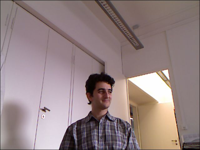

In [ ]:
im.to_thumb(200)

The BIWI dataset contains instructions on how to calculate the point of each picture. We will copy and paste these instuctions.

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [ ]:
get_ctr(fnames[2000])

tensor([350.7250, 294.6427])

We can pass this function to DataBlock as get_y, since it is responsible for labeling each item. We’ll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same person appears in multiple images in this dataset — but we want to ensure that our model can generalise to people that it hasn’t seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function which returns true for just one person, resulting in a validation set containing just that person’s images.

The only other difference to previous data block examples is that the second block is a PointBlock. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images.

In [ ]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock),
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms = [*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]
)

Asterix (*) is used to pass a variable number of arguments to a function, it is mostly used to pass a non-key argument and variable-length argument list.

aug_transforms(...) returns a list, so you need to star it if you put it in another list with additional transforms.

In [ ]:
dls = biwi.dataloaders(path)

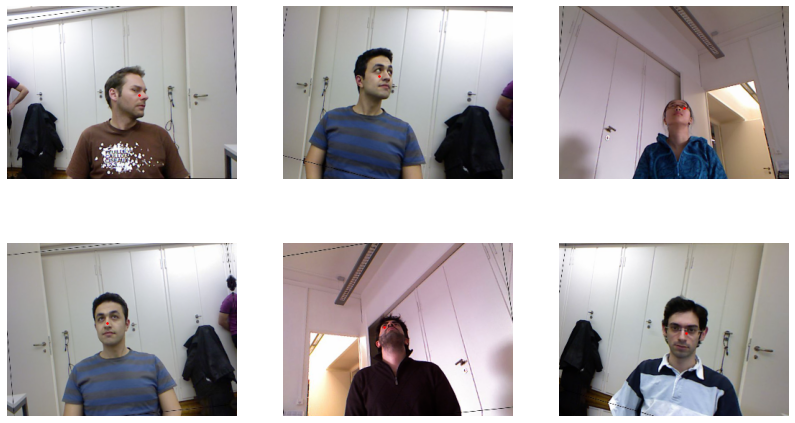

In [ ]:
dls.show_batch(max_n=6, figsize=(14,8))

In [ ]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(1, 5e-3)

  The loss is the mean squared error, meaning that the actual loss is math.sqrt(mse)

In [ ]:
learn.show_results()

## Text transfer learning

In [ ]:
from fastai.text.all import *

#### Sentiment analysis - High level API

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

(#7) [Path('/root/.fastai/data/imdb/imdb.vocab'),Path('/root/.fastai/data/imdb/README'),Path('/root/.fastai/data/imdb/test'),Path('/root/.fastai/data/imdb/unsup'),Path('/root/.fastai/data/imdb/tmp_clas'),Path('/root/.fastai/data/imdb/train'),Path('/root/.fastai/data/imdb/tmp_lm')]

In [ ]:
(path/'train').ls()

(#4) [Path('/root/.fastai/data/imdb/train/neg'),Path('/root/.fastai/data/imdb/train/unsupBow.feat'),Path('/root/.fastai/data/imdb/train/pos'),Path('/root/.fastai/data/imdb/train/labeledBow.feat')]

The data follows an ImageNet-style organization, in the train folder, we have two subfolders, pos and neg (for positive reviews and negative reviews). We can gather it by using the TextDataLoaders.from_folder method. The only thing we need to specify is the name of the validation folder, which is “test” (and not the default “valid”).

In [ ]:
dls = TextDataLoaders.from_folder(path, valid='test')

In [ ]:
dls.show_batch(max_n=2)

As we can see, the library preprocesses our text for us and adds tokens to the text.

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

We use the AWD LSTM architecture.

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass. drop_mult is a parameter that controls the magnitude of all dropouts in that model.  

We use accuracy to track down how well we are doing. We can then fine-tune our pretrained model

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 1e-2)

In [ ]:
learn.fine_tune(4, 1e-2)

In [ ]:
learn.show_results(3)

In [ ]:
learn.predict('I loved that movie!')

#### Sentiment analysis - DataBlock API

To build the datablock we need to pass as args:

* **blocks**, (TextBlock.from_folder(path), CategoryBlock) - we use the from_folder class method to inform fastai that our texts are files in a folder
* **get_items**, get_text_files
* **get_y**, here with the parent folder.
* **splitter**, here with the grandparent folder.

In [ ]:
texts = DataBlock(
    blocks = (TextBlock.from_folder(path), CategoryBlock),
    get_items = get_text_files,
    get_y = parent_label,
    splitter = GrandparentSplitter(valid_name='test')
)

In [ ]:
dls = texts.dataloaders(path)

In [ ]:
dls.show_batch(max_n=3)

### Sentiment analysis - State of the art

The pretrained model we used in the previous section is called a language model. It was pretrained on Wikipedia on the task of guessing the next word, after reading all the words before. We got great results by directly fine-tuning this language model to a movie review classifier, but with one extra step, we can do even better: the Wikipedia English is slightly different from the IMDb English. So instead of jumping directly to the classifier, we could fine-tune our pretrained language model to the IMDb corpus and then use that as the base for our classifier.

One reason, of course, is that it is helpful to understand the foundations of the models that you are using. But there is another very practical reason, which is that you get even better results if you fine tune the (sequence-based) language model prior to fine tuning the classification model. For instance, in the IMDb sentiment analysis task, the dataset includes 50,000 additional movie reviews that do not have any positive or negative labels attached in the unsup folder. We can use all of these reviews to fine tune the pretrained language model — this will result in a language model that is particularly good at predicting the next word of a movie review. In contrast, the pretrained model was trained only on Wikipedia articles.

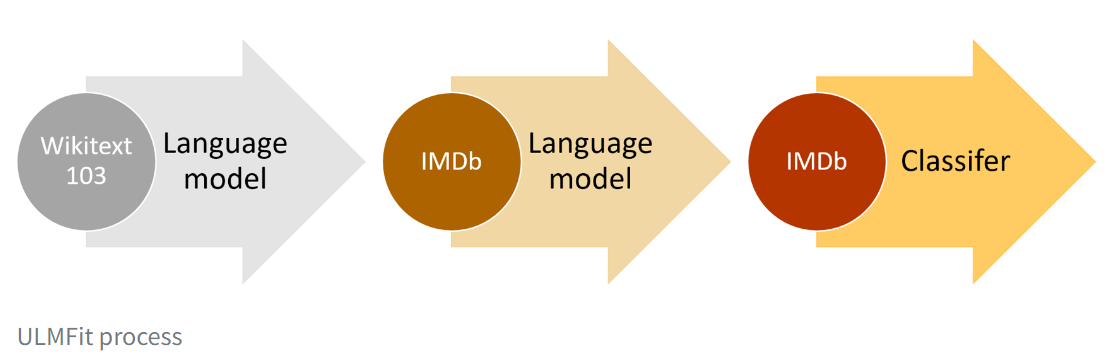

#### Fine-tuning the language model

In [ ]:
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid_pct=0.1)

We need to pass something for valid_pct otherwise this method will try to split the data by using the grandparent folder names. By passing valid_pct=0.1, we tell it to get a random 10% of those reviews for the validation set.

In [ ]:
dls_lm.show_batch(max_n=2)

Since language models tries to guess the next word, we can see that the target is the input, but shiftet one word to the right compared to the input

When creating the learner, we use the AWD_LSTM architecture like before. We use accuracy and perplexity as metrics (the later is the exponential of the loss) and we set a default weight decay of 0.1. to_fp16 puts the Learner in mixed precision, which is going to help speed up training on GPUs that have Tensor Cores.

In [ ]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

Both fine_tune and fit_one_cycle can be used to train this model. However we will stick to fit_one_cycle in this example to showcase how fine_tune actually works. This derives from the fact that fine_tune is actually a function made up of fit_one_cycle and freeze functions.

Note: by default, a pretrained model is in a frozen state, meaning that only the head of the model will train while the body stays frozen.

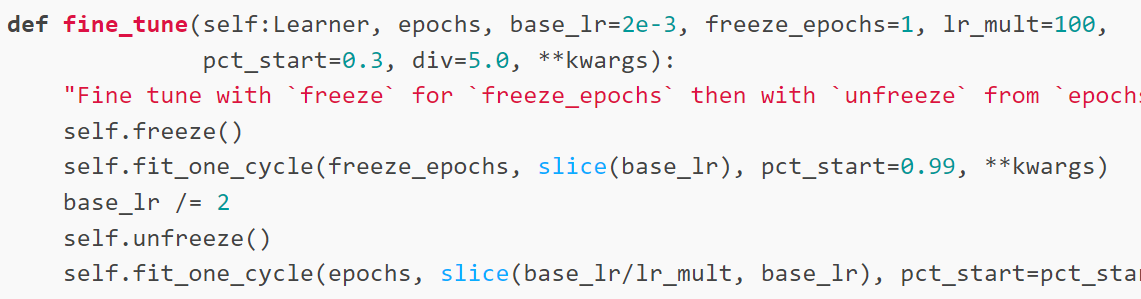

In [ ]:
learn.fit_one_cycle(1, 1e-2)

To save a models intermediate weights, use:

In [ ]:
learn.save('1epoch')

This will first create a file in learn.path/models/ named “1epoch.pth”. 

Then, to load your model on another machine after creating your Learner the same way, or resume training later, use:

In [ ]:
learn = learn.load('1epoch')

Then we will fine_tune our model (mimicing the source code) by first unfreezing our model and then training it for n cycles

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final, task-specific layer(s) is called the encoder. It means much the same thing as body when applied to vision CNNs, but tends to be more used for NLP and generative models. To save it we use:

In [ ]:
learn.save_encoder('finetuned')

Since we have just fine-tuned a generative language model, we can actually use it to create new movie reviews to use as test data later on:

In [ ]:
TEXT = 'I liked this movie because'
N_WORDS = 40
N_SENTENCES = 2

preds = [learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)]
print('\n'.join(preds))

#### Training the classifier

In [ ]:
dls_clas = TextDataLoaders.from_folder(path, valid='test', text_vocab=dls_lm.vocab)

The main difference is that we have to use the exact same vocabulary as when we were fine-tuning our language model, or the weights learned won’t make any sense. We pass that vocabulary with text_vocab.

In [ ]:
dls_clas.show_batch(max_n=1)

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

The difference is that before training it, we load the previous encoder:



In [ ]:
learn = learn.load_encoder('finetuned')

The last step is to train with discriminative learning rates and gradual unfreezing. In computer vision, we often unfreeze the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference.

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In just one epoch we get the same result as our training in the first section, not too bad! We can pass -2 to freeze_to to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

## Tabular training

In [ ]:
from fastai.tabular.all import *

### With soley FastAI

In [ ]:
import pandas as pd

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/models'),Path('/root/.fastai/data/adult_sample/export.pkl')]

In [ ]:
df = pd.read_csv(path/'adult.csv')
df.sample(3)

age workclass  fnlwgt      education  education-num  \
15328   45   Private   97842   Some-college           10.0   
9217    28         ?   55950      Bachelors           13.0   
12448   63         ?  221592        HS-grad            9.0   

            marital-status          occupation relationship    race      sex  \
15328   Married-civ-spouse   Machine-op-inspct      Husband   White     Male   
9217         Never-married                   ?    Own-child   Black   Female   
12448   Married-civ-spouse                   ?      Husband   White     Male   

       capital-gain  capital-loss  hours-per-week  native-country salary  
15328             0             0              65   United-States   <50k  
9217              0             0              40         Germany   <50k  
12448             0             0              40   United-States  >=50k

Some of the columns are continuous (like age) and we will treat them as float numbers we can feed our model directly. Others are categorical (like workclass or education) and we will convert them to a unique index that we will feed to embedding layers. We can specify our categorical and continuous column names, as well as the name of the dependent variable in TabularDataLoaders factory methods:



In [ ]:
dls = TabularDataLoaders.from_csv(
    path/'adult.csv', 
    path=path, 
    y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize]
)

The last part is the list of pre-processors we apply to our data:

* Categorify is going to take every categorical variable and make a map from integer to unique categories, then replace the values by the corresponding index.
* FillMissing will fill the missing values in the continuous variables by the median of existing values (you can choose a specific value if you prefer)
* Normalize will normalize the continuous variables (subtract the mean and divide by the std)

To further expose what’s going on below the surface, let’s rewrite this utilizing fastai’s TabularPandas class. We will need to make one adjustment, which is defining how we want to split our data. By default the factory method above used a random 80/20 split, so we will do the same:

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [ ]:
fastAI_df = TabularPandas(
    df,
    procs = [Categorify, FillMissing, Normalize],
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    y_names = 'salary',
    splits = splits
)

In [ ]:
print(type(fastAI_df))
print(type(fastAI_df.xs))
print(type(fastAI_df.ys))

<class 'fastai.tabular.core.TabularPandas'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
dls = fastAI_df.dataloaders(bs=64)

In [ ]:
dls.show_batch()

Note: Sometimes with tabular data, your y’s may be encoded (such as 0 and 1). In such a case you should explicitly pass y_block = CategoryBlock in your constructor so fastai won’t presume you are doing regression.

In [ ]:
learn = tabular_learner(dls, metrics=accuracy)

We will train it with fit_one_cycle since we don't have a pretrained version of this model

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.show_results()

Show results:

In [ ]:
row, clas, probs = learn.predict(df.iloc[0])
row.show()

To get prediction on a new dataframe, you can use the test_dl method of the DataLoaders. That dataframe does not need to have the dependent variable in its column.

In [ ]:
test_df = df.copy()
test_df.drop(['salary'], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

Then get the predictions:

In [ ]:
learn.get_preds(dl=dl)

Note: Since machine learning models can’t magically understand categories it was never trained on, the data should reflect this. If there are different missing values in your test data you should address this before training

### With other libraries

As mentioned earlier, TabularPandas is a powerful and easy preprocessing tool for tabular data. Integration with libraries such as Random Forests and XGBoost requires only one extra step, that the .dataloaders call did for us. Let’s look at our fastAI_df again. Its values are stored in a DataFrame like object, where we can extract the cats, conts, xs and ys if we want to:

In [ ]:
fastAI_df.xs.iloc[:3]

workclass  education  marital-status  occupation  relationship  race  \
4058          5         10               1          13             2     5   
8051          5         16               5          13             4     5   
1939          2         12               3           8             1     5   

      education-num_na       age    fnlwgt  education-num  
4058                 1  1.420765  1.455653       1.144294  
8051                 1 -1.438641  3.632407      -0.031568  
1939                 1  0.760902  0.056793      -0.423522

Now that everything is encoded, you can then send this off to XGBoost or Random Forests by extracting the train and validation sets and their values:

In [ ]:
X_train, y_train = fastAI_df.train.xs, fastAI_df.train.ys.values.ravel()
X_test, y_test = fastAI_df.valid.xs, fastAI_df.valid.ys.values.ravel()

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

Now we can send this directly in to other learning algorithms

## Collaborative filtering

In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

### Training a model

In [ ]:
import pandas as pd

In [ ]:
path = untar_data(URLs.ML_100k)
path.ls()

(#23) [Path('/root/.fastai/data/ml-100k/u2.test'),Path('/root/.fastai/data/ml-100k/mku.sh'),Path('/root/.fastai/data/ml-100k/u.user'),Path('/root/.fastai/data/ml-100k/u1.base'),Path('/root/.fastai/data/ml-100k/u3.test'),Path('/root/.fastai/data/ml-100k/u.occupation'),Path('/root/.fastai/data/ml-100k/u1.test'),Path('/root/.fastai/data/ml-100k/allbut.pl'),Path('/root/.fastai/data/ml-100k/u.genre'),Path('/root/.fastai/data/ml-100k/u.item')...]

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, usecols=(0,1,2), names=['user', 'movie', 'rating'])

In [ ]:
ratings.sample(3)

user  movie  rating
64158   741    281       2
56632   301    157       2
95001   561    160       3

In [ ]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, usecols=(0,1), names=['movie','title'])

In [ ]:
movies.sample(3)

movie                  title
253     254  Batman & Robin (1997)
808     809      Rising Sun (1993)
1221   1222  Judgment Night (1993)

Now we merge the two dataframes:

In [ ]:
ratings = ratings.merge(movies)
ratings.sample(3)

user  movie  rating                              title
9327    405    423       5  E.T. the Extra-Terrestrial (1982)
49146   846    404       4                   Pinocchio (1940)
15989   356    328       4           Conspiracy Theory (1997)

We can then build a DataLoaders object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of item_name in our case, to use the titles instead of the ids:



In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In [ ]:
dls.show_batch()

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

Note: Remember that a MSE of 0.91 equals accuracy of 0.91**2 = 0.83

### Interpreting results

Let's select a subsample of the ratings to analyse:

In [ ]:
g = ratings.groupby('title')['rating'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
most_rated_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

#### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic “value” of the movie. We can grab the bias of each movie in our top_movies list with the following command:

In [ ]:
movie_bias = learn.model.bias(most_rated_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(bias, title, mean_ratings.loc[title]) for title, bias in zip(most_rated_movies, movie_bias)]

In [ ]:
value = lambda x: x[0]
print('The best movies',*sorted(movie_ratings, key=value, reverse=True)[:10], sep='\n')
print('\nThe worst movies',*sorted(movie_ratings, key=value)[:10], sep='\n')

The best movies
(tensor(0.6281), "Schindler's List (1993)", 4.466442953020135)
(tensor(0.5714), 'Shawshank Redemption, The (1994)', 4.445229681978798)
(tensor(0.5603), 'Titanic (1997)', 4.2457142857142856)
(tensor(0.5464), 'Star Wars (1977)', 4.3584905660377355)
(tensor(0.5412), 'Silence of the Lambs, The (1991)', 4.28974358974359)
(tensor(0.5390), 'Rear Window (1954)', 4.3875598086124405)
(tensor(0.5028), 'L.A. Confidential (1997)', 4.161616161616162)
(tensor(0.5011), 'Usual Suspects, The (1995)', 4.385767790262173)
(tensor(0.4986), 'Good Will Hunting (1997)', 4.262626262626263)
(tensor(0.4942), 'As Good As It Gets (1997)', 4.196428571428571)

The worst movies
(tensor(-0.3569), 'Children of the Corn: The Gathering (1996)', 1.3157894736842106)
(tensor(-0.3006), 'Crow: City of Angels, The (1996)', 1.9487179487179487)
(tensor(-0.2813), 'Lawnmower Man 2: Beyond Cyberspace (1996)', 1.7142857142857142)
(tensor(-0.2498), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232)
(tensor(-0.24

#### Movie weights

Now let’s try to analyze the latent factors our model has learned. We can grab the weights for each movie in top_movies the same way as we did for the bias before.

In [ ]:
movie_weights = learn.model.weight(most_rated_movies, is_item=True)
movie_weights.shape

torch.Size([1000, 50])

Now let's perform a PrincipalComponentAnalysis and reduce our dimensions from 50 to 3 in order to see if we can decipher what the model has learned. Remember that PCA tries to choose the variables with the most variance i.e the variables that has the most impact on the rating of a movie. 

In [ ]:
movie_pca = movie_weights.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
f1,f2,f3 = movie_pca.t()

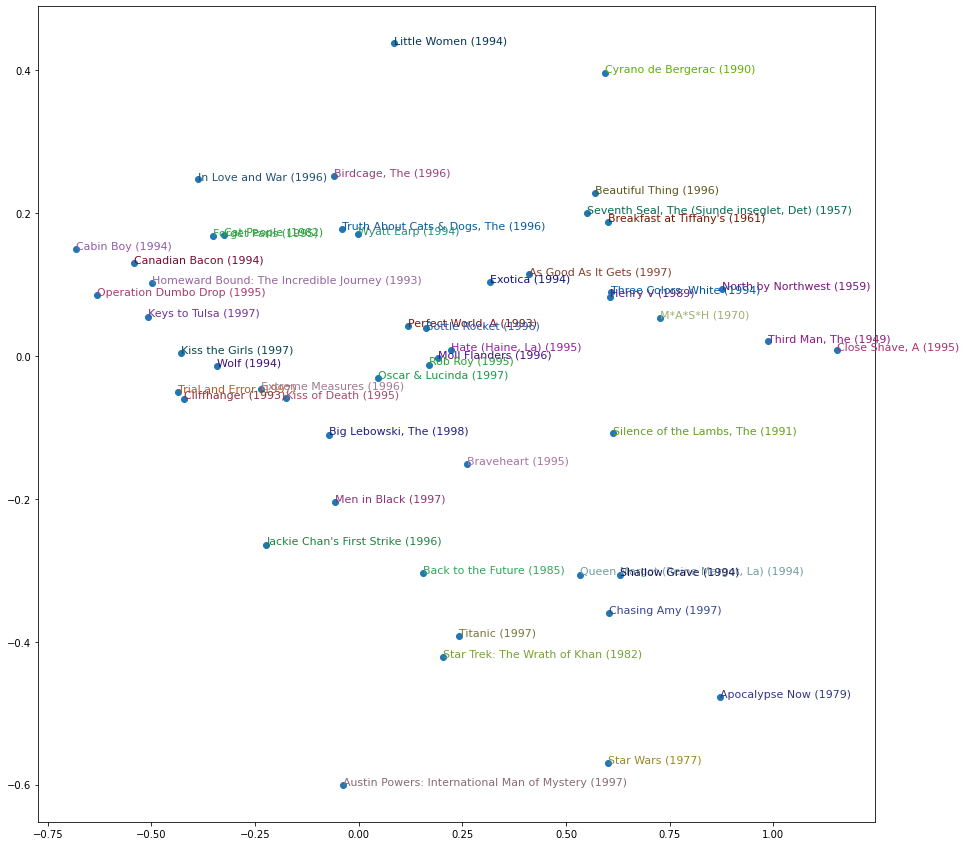

In [ ]:
idxs = list(np.random.choice(len(most_rated_movies), 50, replace=False))
X = f1[idxs]
Y = f3[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(most_rated_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()